## TIC-TAC-TOE

In [61]:

import operator
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count


/home/roman/anaconda3/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


# 1. Q learning

## 3x3

In [1031]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [ ]:
# окружение крестики-нолики

In [1032]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        #print("action: ", action)
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [ ]:
# стратегия

In [909]:
class Strategy():
    def __init__(self, epsilon=0.1, random=False):
        self.Q = {}
        self.epsilon = epsilon
        self.random = random # 1 - случайная стратегия
    
    
    def putNewSandA(self, s, actions): # добавляем новые значения state и actions 
        #print("Q:", self.Q)
        if not self.random:
            #print("неслучайная стр")
            if s not in self.Q:
                    self.Q[s] = {} #np.zeros(num_actions)
                    
            for action in actions:
                    t_action = tuple(action)
                    if t_action not in self.Q[s]:
                        #t_action = tuple(action)
                        self.Q[s][t_action] = 0
                        #self.Q[s][t_action] = np.random.rand() * 2 - 1
    
    
    def getAction(self, s, actions):            
        self.putNewSandA(s, actions)            
                
        if np.random.rand() < self.epsilon or self.random:
            ind = np.random.randint(len(actions))
            return actions[ind]
        else:
            best_action = None
            best_q = -100000
            for action in actions:
                t_action = tuple(action)
                if self.Q[s][t_action] > best_q:
                    best_q = self.Q[s][t_action]
                    best_action = t_action
            #best_action = max(self.Q[s].items(), key=operator.itemgetter(1))[0]
            #print("allowed actions: ", actions)
            #print("Q[s]")
            #print(self.Q[s])
            #print("best_action:", np.array(best_action))
            return np.array(best_action)
     
    
    def getMaxQ(self, s):
        if not self.random:
            if s not in self.Q:
                return 0
            else:
                best_q = max(self.Q[s].values())
                return best_q 
        else:
            return 0
        
        
    def updateQ(self, s, action, next_state, r):
        #print("r ", r)
        if not self.random:
            nextQ = self.getMaxQ(next_state)
            t_action = tuple(action)
            #print("s: ", s)
            #print("action: ", action)
            #print("Q: ", self.Q)
            #print("Q[s][action]: ", self.Q[s][t_action])
            #print(ALPHA)
            #tt = ALPHA(r + GAMMA * nextQ - self.Q[s][t_action])
            #print(tt)
            #print("taction: ", t_action)
            #print("before:", self.Q[s][t_action])
            #print("add ", ALPHA * (r + GAMMA * nextQ - self.Q[s][t_action]))
            self.Q[s][t_action] += ALPHA * (r + GAMMA * nextQ - self.Q[s][t_action])
            #self.Q[s][t_action] += ALPHA * (r - self.Q[s][t_action])

In [974]:
def plot_test_game(env, p1, p2):
    n_games = 0
    games_res = []
    while n_games < TOTAL_GAMES:
        done = 0
        p1, p2 = 0, 0
        env.reset()
        
        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1: # выбирает действие 1ый
                if p1: # если 1ый уже ходил, обновляем Q для него
                    pi1.updateQ(s1, a1, s, reward)
                a = pi1.getAction(s, actions)
                a1 = a
                p1 = 1
                s1 = s
            else:
                if p2:
                    pi2.updateQ(s2, a2, s, -reward)
                #print("actions at p2:", actions)    
                a = pi2.getAction(s, actions)
                a2 = a
                p2 = 1
                s2 = s
            observation, reward, done, info = env.step(a)
            #print("done: ", done)
            #print("emptyspaces: ", env.getEmptySpaces())

            
            if done:
                pi1.updateQ(s1, a1, env.getHash(), reward)
                pi2.updateQ(s2, a2, env.getHash(), -reward)
                if n_games % 1000 == 0:
                    pi1.epsilon /= 1.2
                    pi2.epsilon /= 1.2
                    
                #pi1.eps = 0.005 * 0.99 ** n_games
                #pi2.eps = 0.005 * 0.99 ** n_games
                n_games += 1
                games_res.append(reward)
                if n_games % 10000 == 0:
                    print("eps = ", pi1.epsilon)
                    print(n_games, "игр")
                    print("доля побед стратегии 1 за последние 10000 игр: ", sum(1 for g in games_res[-10000:] if g == 1) / 10000)
                    print("доля побед стратегии 2 за последние 10000 игр: ", sum(1 for g in games_res[-10000:] if g == -1) / 10000)

    return games_res
    
    

## Обучаем игрока, играющего "крестиками"

In [975]:
ALPHA = 0.002
GAMMA = 0.99
TOTAL_GAMES = 100000

In [976]:
pi1 = Strategy(epsilon=0.5)
pi2 = Strategy(random=True)
env = TicTacToe()

In [977]:
games_res = plot_test_game(env, pi1, pi2)

eps =  0.0807527914449229
10000 игр
доля побед стратегии 1 за последние 10000 игр:  0.8588
доля побед стратегии 2 за последние 10000 игр:  0.0842
eps =  0.013042026652294427
20000 игр
доля побед стратегии 1 за последние 10000 игр:  0.9515
доля побед стратегии 2 за последние 10000 игр:  0.0222
eps =  0.0021063601165437155
30000 игр
доля побед стратегии 1 за последние 10000 игр:  0.9645
доля побед стратегии 2 за последние 10000 игр:  0.0156
eps =  0.00034018891839831633
40000 игр
доля побед стратегии 1 за последние 10000 игр:  0.9699
доля побед стратегии 2 за последние 10000 игр:  0.0119
eps =  5.4942409558586254e-05
50000 игр
доля побед стратегии 1 за последние 10000 игр:  0.9675
доля побед стратегии 2 за последние 10000 игр:  0.0125
eps =  8.87350588113211e-06
60000 игр
доля побед стратегии 1 за последние 10000 игр:  0.9696
доля побед стратегии 2 за последние 10000 игр:  0.0106
eps =  1.4331207396087158e-06
70000 игр
доля побед стратегии 1 за последние 10000 игр:  0.9668
доля побед стр

## Построим зависимость средней доли выигранных партий от кол-ва игр

In [978]:
width = 500
ind = [i * width for i in range(1, len(games_res) // width)]
avers = []
for i in ind:
    sub = games_res[i-width:i]
    aver = sum(1 for x in sub if x == 1) / width
    avers.append(aver)

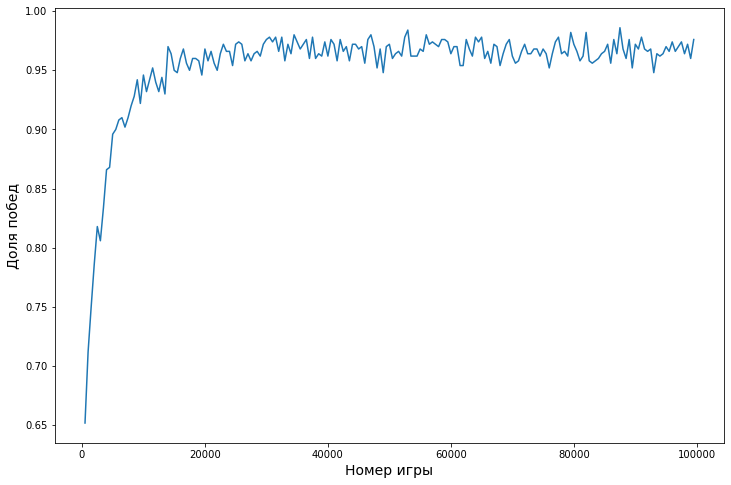

In [985]:
plt.figure(figsize=(12,8))
plt.plot(ind, avers)
plt.xlabel("Номер игры", fontsize=14)
plt.ylabel("Доля побед", fontsize=14)
plt.show()

## Аналогично, для "ноликов"

In [986]:
pi1 = Strategy(random=True)
pi2 = Strategy(epsilon=0.5)
env = TicTacToe()

In [987]:
games_res = plot_test_game(env, pi1, pi2)

eps =  0.016150558288984578
10000 игр
доля побед стратегии 1 за последние 10000 игр:  0.2304
доля побед стратегии 2 за последние 10000 игр:  0.6286
eps =  0.0026084053304588845
20000 игр
доля побед стратегии 1 за последние 10000 игр:  0.0705
доля побед стратегии 2 за последние 10000 игр:  0.7978
eps =  0.000421272023308743
30000 игр
доля побед стратегии 1 за последние 10000 игр:  0.0549
доля побед стратегии 2 за последние 10000 игр:  0.8151
eps =  6.803778367966324e-05
40000 игр
доля побед стратегии 1 за последние 10000 игр:  0.0512
доля побед стратегии 2 за последние 10000 игр:  0.8215
eps =  1.098848191171725e-05
50000 игр
доля побед стратегии 1 за последние 10000 игр:  0.0474
доля побед стратегии 2 за последние 10000 игр:  0.8219
eps =  1.7747011762264216e-06
60000 игр
доля побед стратегии 1 за последние 10000 игр:  0.0549
доля побед стратегии 2 за последние 10000 игр:  0.8177
eps =  2.866241479217432e-07
70000 игр
доля побед стратегии 1 за последние 10000 игр:  0.0467
доля побед ст

In [988]:
width = 500
ind = [i * width for i in range(1, len(games_res) // width)]
avers = []
for i in ind:
    sub = games_res[i-width:i]
    aver = sum(1 for x in sub if x == -1) / width
    avers.append(aver)

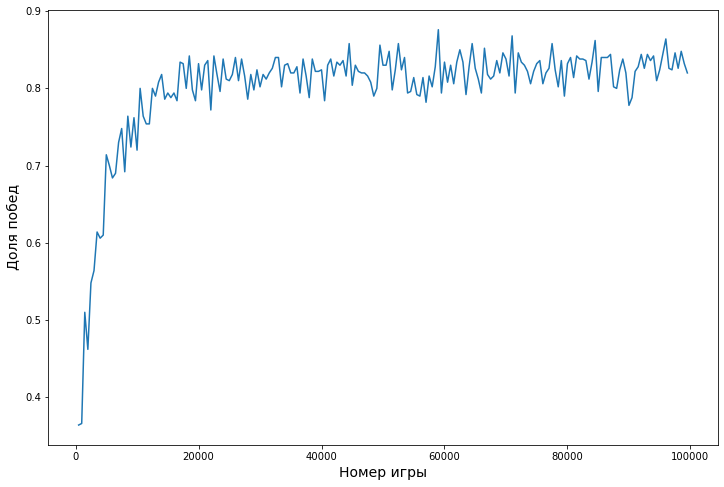

In [989]:
plt.figure(figsize=(12,8))
plt.plot(ind, avers)
plt.xlabel("Номер игры", fontsize=14)
plt.ylabel("Доля побед", fontsize=14)
plt.show()

## Итак, при табличном Q обучении при обучении "крестикам" доля побед примерно 0.96, при обучении "ноликам" - 0.83

## Доска 5х5, победа при 4ех подряд идущих крестиках или ноликах

In [990]:
pi1 = Strategy(random=True)
pi2 = Strategy(epsilon=0.5)
env = TicTacToe(n_rows=5, n_cols=5, n_win=4)

In [ ]:
# будем уменьшать eps в 1.1 раз после каждой 1000 игры

In [996]:
def plot_test_game(env, p1, p2):
    n_games = 0
    games_res = []
    while n_games < TOTAL_GAMES:
        done = 0
        p1, p2 = 0, 0
        env.reset()
        
        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1: # выбирает действие 1ый
                if p1: # если 1ый уже ходил, обновляем Q для него
                    pi1.updateQ(s1, a1, s, reward)
                a = pi1.getAction(s, actions)
                a1 = a
                p1 = 1
                s1 = s
            else:
                if p2:
                    pi2.updateQ(s2, a2, s, -reward)
                #print("actions at p2:", actions)    
                a = pi2.getAction(s, actions)
                a2 = a
                p2 = 1
                s2 = s
            observation, reward, done, info = env.step(a)
            #print("done: ", done)
            #print("emptyspaces: ", env.getEmptySpaces())

            
            if done:
                pi1.updateQ(s1, a1, env.getHash(), reward)
                pi2.updateQ(s2, a2, env.getHash(), -reward)
                if n_games % 1000 == 0:
                    pi1.epsilon /= 1.1
                    pi2.epsilon /= 1.1
                    
                #pi1.eps = 0.005 * 0.99 ** n_games
                #pi2.eps = 0.005 * 0.99 ** n_games
                n_games += 1
                games_res.append(reward)
                if n_games % 10000 == 0:
                    print("eps = ", pi1.epsilon)
                    print(n_games, "игр")
                    print("доля побед стратегии 1 за последние 10000 игр: ", sum(1 for g in games_res[-10000:] if g == 1) / 10000)
                    print("доля побед стратегии 2 за последние 10000 игр: ", sum(1 for g in games_res[-10000:] if g == -1) / 10000)

    return games_res
    
    

## За "крестики"

In [997]:
ALPHA = 0.002
GAMMA = 0.99
TOTAL_GAMES = 100000

In [998]:
pi1 = Strategy(epsilon=0.5)
pi2 = Strategy(random=True)
env = TicTacToe(n_rows=5, n_cols=5, n_win=4)

In [999]:
games_res = plot_test_game(env, pi1, pi2)

eps =  0.1927716447147657
10000 игр
доля побед стратегии 1 за последние 10000 игр:  0.7896
доля побед стратегии 2 за последние 10000 игр:  0.188
eps =  0.07432181401207172
20000 игр
доля побед стратегии 1 за последние 10000 игр:  0.8637
доля побед стратегии 2 за последние 10000 игр:  0.1257
eps =  0.028654276650583968
30000 игр
доля побед стратегии 1 за последние 10000 игр:  0.8924
доля побед стратегии 2 за последние 10000 игр:  0.0989
eps =  0.011047464076089959
40000 игр
доля побед стратегии 1 за последние 10000 игр:  0.8995
доля побед стратегии 2 за последние 10000 игр:  0.0935
eps =  0.004259275639750303
50000 игр
доля побед стратегии 1 за последние 10000 игр:  0.9014
доля побед стратегии 2 за последние 10000 игр:  0.0924
eps =  0.0016421351407364037
60000 игр
доля побед стратегии 1 за последние 10000 игр:  0.9007
доля побед стратегии 2 за последние 10000 игр:  0.0932
eps =  0.0006331141838473395
70000 игр
доля побед стратегии 1 за последние 10000 игр:  0.8975
доля побед стратегии 

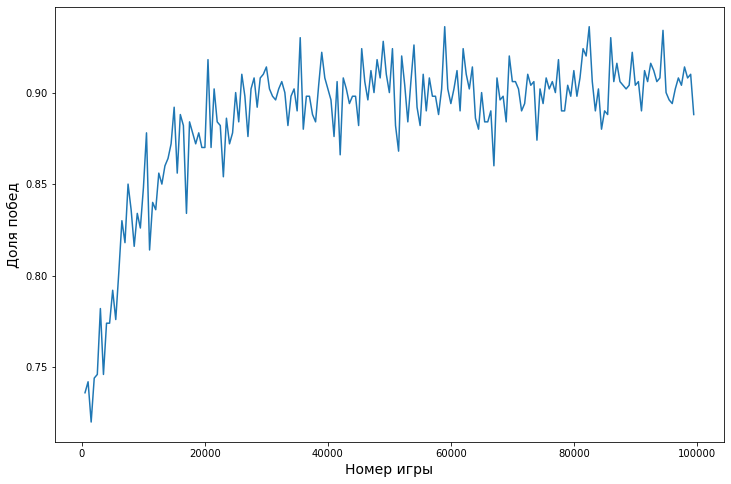

In [1000]:
width = 500
ind = [i * width for i in range(1, len(games_res) // width)]
avers = []
for i in ind:
    sub = games_res[i-width:i]
    aver = sum(1 for x in sub if x == 1) / width
    avers.append(aver)

plt.figure(figsize=(12,8))
plt.plot(ind, avers)
plt.xlabel("Номер игры", fontsize=14)
plt.ylabel("Доля побед", fontsize=14)
plt.show()    

## За "нолики"

In [1002]:
pi1 = Strategy(random=True)
pi2 = Strategy(epsilon=0.5)
env = TicTacToe(n_rows=5, n_cols=5, n_win=4)

In [1003]:
games_res = plot_test_game(env, pi1, pi2)

eps =  0.03855432894295315
10000 игр
доля побед стратегии 1 за последние 10000 игр:  0.2984
доля побед стратегии 2 за последние 10000 игр:  0.685
eps =  0.014864362802414351
20000 игр
доля побед стратегии 1 за последние 10000 игр:  0.2247
доля побед стратегии 2 за последние 10000 игр:  0.7668
eps =  0.005730855330116797
30000 игр
доля побед стратегии 1 за последние 10000 игр:  0.194
доля побед стратегии 2 за последние 10000 игр:  0.8014
eps =  0.002209492815217993
40000 игр
доля побед стратегии 1 за последние 10000 игр:  0.1902
доля побед стратегии 2 за последние 10000 игр:  0.8051
eps =  0.0008518551279500608
50000 игр
доля побед стратегии 1 за последние 10000 игр:  0.1856
доля побед стратегии 2 за последние 10000 игр:  0.8085
eps =  0.00032842702814728074
60000 игр
доля побед стратегии 1 за последние 10000 игр:  0.1871
доля побед стратегии 2 за последние 10000 игр:  0.8093
eps =  0.00012662283676946793
70000 игр
доля побед стратегии 1 за последние 10000 игр:  0.1905
доля побед страте

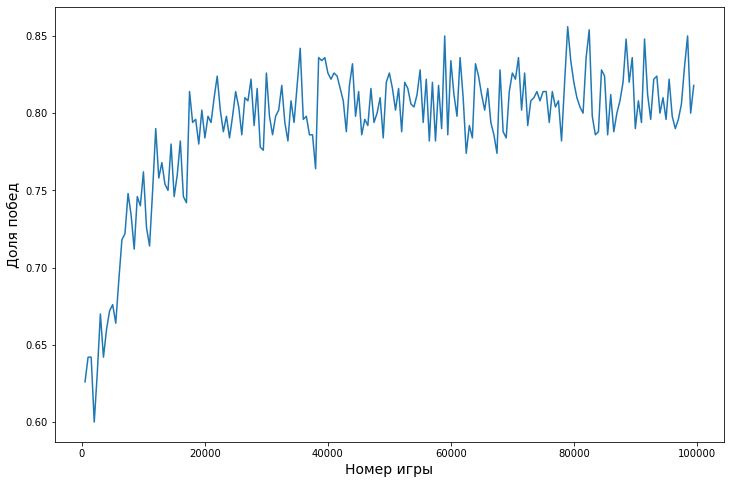

In [1004]:
width = 500
ind = [i * width for i in range(1, len(games_res) // width)]
avers = []
for i in ind:
    sub = games_res[i-width:i]
    aver = sum(1 for x in sub if x == -1) / width
    avers.append(aver)

plt.figure(figsize=(12,8))
plt.plot(ind, avers)
plt.xlabel("Номер игры", fontsize=14)
plt.ylabel("Доля побед", fontsize=14)
plt.show()  

## Итак, при игре в поле 5х5 (для победы нужно поставить 4 крестика/нолика рядом) доля побед становится немного меньше, но по-прежнему обучение есть